# Evaluate our methods's search performance

In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../Wormholes') # where the wormholes package is
from pathlib import Path

from wormholes import *
from wormholes.perturb import *
from wormholes.tools.triplets_vis_tools import *
import matplotlib.pyplot as plt
from argparse import Namespace

import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load the viewer
exp_root = f"{PROJECT_ROOT}/results/cache/gen_v10-our"
viewer = TripletViewerMetaTokensSearch(f"{exp_root}/meta_job0.nc")

# load subject model (vanilla CNN)
from wormholes.perturb.utils import *
imagenet_ds = RestrictedImageNet(f"{PROJECT_ROOT}/data/ilsvrc")
get_mapped_RIN = lambda resume_name: get_restricted_imagenet_mapped_model(arch='resnet50', 
                                                                  restricted_imagenet_ds=imagenet_ds, 
                                                                  pytorch_pretrained=False, 
                                                                  resume_path=f"{PROJECT_ROOT}/checkpoints/{resume_name}")[0].eval()


model_subject_maker = partial(get_mapped_RIN, 'imagenet_vanilla_v2.pt')
model_subject = model_subject_maker().eval()




=> loading checkpoint '/home/young/workspace/reconstruction/Wormholes/checkpoints/imagenet_vanilla_v2.pt'
=> loaded checkpoint '/home/young/workspace/reconstruction/Wormholes/checkpoints/imagenet_vanilla_v2.pt' (epoch 171)


In [18]:
# load display info
source_dir  = Path(f"{PROJECT_ROOT}/exp-source")
display_info= np.load(source_dir/'display_info.npy', allow_pickle=True)
print('# of displays:', len(display_info))

# of displays: 2000


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [38:36<00:00,  1.16s/it]

priority our correct 781/1000, 0.781, for foveated
turtle: # of data 250, mean acc: 0.692
dog: # of data 250, mean acc: 0.82
bird: # of data 250, mean acc: 0.908
insect: # of data 250, mean acc: 0.704
entropy:
# low  1.3687642097473145 400 # high  1.3824200868606566 400
average value  1.3748910565376282


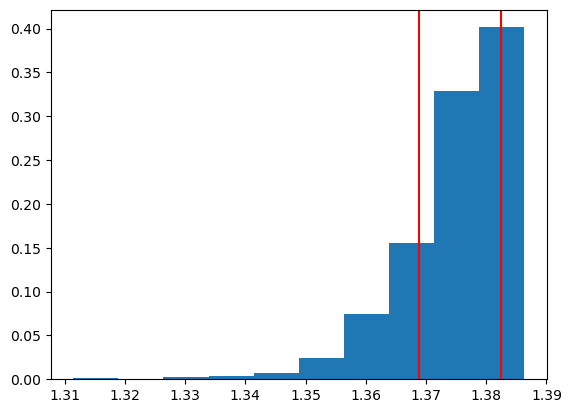

(2000,)


In [10]:

# load the setup
img_resolution = 'clean' #'foveated' or 'clean' or 'blurred'
budget = 40 # budget used to generate the modified images
model_name = 'resnet50_robust_mapped_RIN_l2_3_0' # model used to generate the modified images
save_viewer_results = Path(f"{PROJECT_ROOT}/exp-source/viewer_results")

target_label ='all' #'all' or 'turtle', 'dog', 'bird', 'insect'
if target_label == 'all':
    display_info_target = [info for info in display_info if info['target_label'] != 'cat'] # cat is not part of evaluation, just for generating practice trials
else:
    display_info_target = [info for info in display_info if info['target_label'] == target_label]

# n_images = 10
n_images = len(display_info_target) # all

our_results = []
for info in tqdm(display_info_target[:n_images]):
    display_idx = info['display_idx']
    display_filename = info['display_filename']

    dict_true = dict(budget=budget,
                    model_name=model_name, 
                    target_class_name = info['target_label'],
                    )

    dict_false = dict()

    results = viewer(dict_true, dict_false, 
                    n_select=4, 
                    include_files =  ['/'.join(str(path).split('/')[2:]) for path in info[f'{img_resolution}_objlist']], # None or list of files to include
                    exclude_files = None, # None or list of files to exclude
                    model_subject= model_subject,
                    title=model_name.replace('_', ' '),
                    filename= save_viewer_results/f'{display_filename}_{img_resolution}.png',
                    visualize=False, 

    )

    plt.show()

    # add acc and priority value
    results['display_idx'] = display_idx
    if info['condition'] == 'TP':
        results['our_acc'] = 1 if np.argmin(results['budget_usage']) == info['target_idx_in_objlist'] else 0
    else:
        results['our_acc'] = None
    results['our_priority_value'] =  F.softmax(torch.tensor(-np.array(results['budget_usage'])), dim=0).tolist()
    results['entropy'] =  Categorical(probs = torch.Tensor(results['our_priority_value'])).entropy().item()
    our_results.append(results)


# print acc and priority results
accs = [results['our_acc'] for results in our_results if results['our_acc'] is not None]
print(f'priority our correct {np.sum(accs).round(3)}/{len(accs)}, {np.mean(accs).round(3)}, for {img_resolution}')

for target in ['turtle', 'dog', 'bird', 'insect']:
    target_display_indices = []
    for info in display_info:
        if info['condition']=='TP' and info['target_label'] == target:
            target_display_indices.append(info['display_idx'])

    target_accs = [results['our_acc'] for results in our_results if results['display_idx'] in target_display_indices]
    print(f'{target}: # of data {len(target_accs)}, mean acc: {np.mean(target_accs)}')


# draw distribution of entropy and assign categorial class (top 20% and bottom 20%)
from scripts.entropyclass import get_entropy_class
print('entropy:')
all_entropy = []
for result in our_results:
    all_entropy.append(result['entropy'])

entropy_classes = get_entropy_class(np.array(all_entropy))
for i, result in enumerate(our_results):
    result['entropy_class'] = entropy_classes[i]


In [13]:
# save our results
save_path = Path(f'../exp-source/our_results_{img_resolultion}.npy')
if save_path.exists():
    raise ValueError('file exists')

np.save(save_path, our_results, allow_pickle=True)
print('our results saved')

our results saved


# generate modified displays and target maps

In [53]:
import matplotlib.colors as mcolors
from torchvision.transforms.functional import gaussian_blur

In [58]:
# load display info and our results
img_resolution = 'clean' #'foveated' or 'clean' or 'blurred'
source_dir  = Path(f"{PROJECT_ROOT}/exp-source")
modified_dir =  Path(f'{PROJECT_ROOT}/results/cache/gen_v10-our/images')
display_info = np.load(source_dir/'display_info.npy', allow_pickle=True)
display_info = [info for info in display_info if info['target_label'] != 'cat']
print(f'# of displays {img_resolution}:', len(display_info))
our_results = np.load(Path(f'../exp-source/our_results_{img_resolution}.npy'), allow_pickle=True)

# screen info
screen_size = (1680, 1050)
BACKGROUND_COLOR= 128


# of displays clean: 2000


In [61]:
SAVE_OUTPUT = True
VISUALIZE = False

if SAVE_OUTPUT:
    SAVE_DIR_MODIFIED = source_dir/f'display_{img_resolution}_modified'
    SAVE_DIR_MODIFIED.mkdir(exist_ok=True)
    SAVE_DIR_PIXELDIFF = source_dir/f'our_pixeldiff_maps_{img_resolution}'
    SAVE_DIR_PIXELDIFF.mkdir(exist_ok=True)
    SAVE_DIR_PRIORITY = source_dir/f'our_priority_maps_{img_resolution}'
    SAVE_DIR_PRIORITY.mkdir(exist_ok=True)
    

for info in tqdm(display_info):
    # if info['display_idx']!=381:#370
    #     continue
    results = list(filter(lambda x: x['display_idx']==info['display_idx'], our_results))[0]
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))

    # load original display
    orig_display = Image.open(source_dir/'display_clean'/str(info['display_filename']+'.png'))
    axs[0].imshow(orig_display)

    # modified display
    mod_display = np.full((min(screen_size),min(screen_size),3), BACKGROUND_COLOR, dtype=np.uint8)
    for object_path, bbox in zip(results['modified_objlist'], info['bboxlist']):
        # original object size
        xmin, ymin, xmax, ymax = bbox
        orig_width = xmax-xmin
        orig_height = ymax-ymin

        # add modified object
        modified_object = Image.open(object_path) 
        mod_width, mod_height = modified_object.size  # it's resized to 256, then center cropped to fit the model to 224, so we have to resize it back to the original size 
        padded_object = Image.new('RGB', (256, 256), color=(BACKGROUND_COLOR, BACKGROUND_COLOR, BACKGROUND_COLOR))
        padded_object.paste(modified_object, ((orig_width-mod_width)// 2, (orig_height-mod_height)// 2))
        padded_object = padded_object.resize((orig_width, orig_height))
        mod_display[ymin:ymax, xmin:xmax] = padded_object


    axs[1].imshow(mod_display)

    # get difference map (reconstruction cost)
    squared_diff = (np.array(mod_display)-np.array(orig_display))**2
    # axs[2].imshow(squared_diff)
    squared_diff_value = mcolors.rgb_to_hsv(squared_diff)[:, :, 2] # change to HSV (Hue, Saturation, Value), and use only Value (brightness)
    axs[2].imshow(squared_diff_value, cmap='gist_gray')

    #costmap = gaussian_blur(Image.fromarray(squared_diff_value), kernel_size=(81, 81), sigma=(21, 21))
    norm_diff = (squared_diff_value - squared_diff_value.min()) / (squared_diff_value.max() - squared_diff_value.min())
    gamma = 20.0  # or choose any gamma > 1 to amplify high values
    amplified_diff = norm_diff ** gamma
    costmap = gaussian_blur(Image.fromarray((amplified_diff * 255).astype(np.uint8)),  kernel_size=(31, 31), sigma=(6, 6))
    norm_diff = (np.array(costmap) - np.array(costmap).min()) / (np.array(costmap).max() - np.array(costmap).min())
    costmap = (norm_diff*255).astype(np.uint8)


    #costmap = gaussian_blur(Image.fromarray(squared_diff_value), kernel_size=(31, 31), sigma=(5, 5))
    axs[3].imshow(np.array(costmap), cmap='gist_gray', interpolation='nearest')# cmap='gist_gray_r') #'gray'cmap='coolwarm'

    if SAVE_OUTPUT:
        Image.fromarray(np.array(mod_display)).save(SAVE_DIR_MODIFIED/f'{info["display_filename"]}.png')
        Image.fromarray(np.array(squared_diff_value)).convert('RGB').save(SAVE_DIR_PIXELDIFF/f'{info["display_filename"]}.png')
        Image.fromarray(np.array(costmap)).convert('RGB').save(SAVE_DIR_PRIORITY/f'{info["display_filename"]}.png')
         
    # pretify figure
    for ax in axs:
        ax.axis('off')

    if VISUALIZE:
        plt.tight_layout()
        plt.show()
    else:
        plt.close()


# Image.fromarray(np.array(costmap)).convert('RGB').save(f'../figures/savefig/{info["display_filename"]}.png')

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [12:28<00:00,  2.67it/s] 


In [48]:
# Image.fromarray(np.array(costmap)).convert('RGB').save(f'../figures/savefig/{info["display_filename"]}.png')

In [ ]:
# # modify our results

# import numpy as np
# from scipy.special import softmax

# load stimuli info with model priority
# DIR_STIMULI = '../exp-source/exp_datasource/screen_images/'
# TARGET_CATEGORIES = ['dog', 'bird', 'turtle', 'insect']

# display_info =  np.load('../exp-source/display_info.npy', allow_pickle=True)
# print('# of total stimuli: ', len(display_info))
# display_info[0]

# IMAGE_TYPE  = 'clean' # 'blurred', 'foveated', 'clean'
# our_results =  np.load(f'../exp-source/our_results_{IMAGE_TYPE}.npy', allow_pickle=True)
# our_results[0]

# new_results = []
# for res in our_results:
#     display_idx = res['display_idx']
#     info = list(filter(lambda x: x['display_idx'] == display_idx, display_info))[0]
#     d_results = {}
#     d_results['display_idx'] = display_idx
#     d_results['display_filename'] = info['display_filename']
#     d_results['condition'] = info['condition']
#     d_results['target_label'] = info['target_label']
#     d_results['target_index'] = info['target_index']
#     d_results['view_sampling_seed'] = res['view_sampling_seed']
#     d_results['original_objlist'] = ['../data/' + path for path in res['original_objlist']]
#     d_results['modified_objlist'] = ['../results/cache/gen_v10/images/' + path for path in res['modified_objlist']]
#     d_results['target_idx_in_objlist'] = info['target_idx_in_objlist']
#     d_results['budget'] = res['budget']
#     d_results['budget_usage'] = res['budget_usage']
#     d_results['probs'] = list(softmax(-np.array(res['budget_usage'])))
#     d_results['acc'] = res['our_acc']
#     d_results['cnn_pred_logits_orig'] = res['cnn_pred_logits_orig']
#     d_results['cnn_pred_logits_mod'] = res['cnn_pred_logits_mod']
#     new_results.append(d_results)

# print(len(new_results))
# np.save(f'../exp-source/our_results_{IMAGE_TYPE}.npy', new_results)
# print('saved!')


{'display_idx': 2099,
 'display_filename': 'TA_insect_d2099',
 'condition': 'TA',
 'target_label': 'insect',
 'target_index': 8,
 'clean_objlist': ['../data/imagenet_val_segmented_resized/nontarget/n01943899_ILSVRC2012_val_00040963.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n07753113_ILSVRC2012_val_00038688.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n03770679_ILSVRC2012_val_00041846.JPEG',
  '../data/imagenet_val_segmented_resized/nontarget/n04380533_ILSVRC2012_val_00002264.JPEG'],
 'foveated_objlist': ['../data/imagenet_val_segmented_resized_foveated/nontarget/TA_insect_d2099-b0-n01943899_ILSVRC2012_val_00040963.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TA_insect_d2099-b1-n07753113_ILSVRC2012_val_00038688.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TA_insect_d2099-b2-n03770679_ILSVRC2012_val_00041846.JPEG',
  '../data/imagenet_val_segmented_resized_foveated/nontarget/TA_insect_d2099-b3-n04380533_ILSVRC20